In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib 
from scipy.signal import savgol_filter
from numba import njit 
import pandas as pd
from scipy.stats import gamma
import ruptures as rpt
from scipy.optimize import curve_fit

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 19

In [3]:
def compute_sd(traj):      
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values
    x0 = x[0]
    y0 = y[0]
    return np.sqrt( (x-x0)**2 + (y-y0)**2)

In [4]:
import re 

def extract_in_pair_intervals(obs_str):
    intervals = []
    
    # Case: 'In pairs until frame 114'
    match = re.search(r'In pairs until frame (\d+)', obs_str)
    if match:
        end = int(match.group(1))
        intervals.append((0, end))

    # Case: 'In pairs between frames 78 and 139'
    matches = re.findall(r'In pairs between frames (\d+) and (\d+)', obs_str)
    for start, end in matches:
        intervals.append((int(start), int(end)))

    # Case: 'Not in pairs between frames 7 and 32, and frames 141 and 175'
    # => we infer 'in pairs' as complement
    not_in_pairs = re.findall(r'frames (\d+) and (\d+)', obs_str)
    if 'Not in pairs' in obs_str and not_in_pairs:
        not_intervals = [(int(start), int(end)) for start, end in not_in_pairs]
        # Assume a global time range if needed (you can pass this in)
        min_frame, max_frame = 0, 10**6
        # Compute complement
        current = min_frame
        for start, end in sorted(not_intervals):
            if current < start:
                intervals.append((current, start - 1))
            current = end + 1
        if current <= max_frame:
            intervals.append((current, max_frame))

    return intervals
def is_in_pair(frame, obs_str):
    intervals = extract_in_pair_intervals(obs_str)
    return any(start <= frame <= end for start, end in intervals)

In [5]:

def piecewise_gamma(x, x0, y0, k, theta):
    """
    Piecewise function:
    - Returns y0 for x <= x0
    - Follows a Gamma distribution for x > x0
    
    Parameters:
    x : float or array-like
        Input value(s)
    x0 : float
        Threshold value
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    
    Returns:
    float or array-like: Evaluated function values
    """
    x = np.asarray(x)  # Ensure x is an array for vectorized operations
    gamma_values = gamma.pdf(x - x0, a=k, scale=theta)  # Gamma PDF shifted by x0
    return np.where(x < x0, y0, gamma_values)



def mean_piecewise(x0, y0, k, theta, a, b):
    """
    Computes the mean of the piecewise function over [a, b].

    Parameters:
    x0 : float
        Threshold separating constant and gamma regions
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    a, b : float
        Integration limits
    
    Returns:
    float: Mean of the function over [a, b]
    """
    # Constant region integral
    I1 = y0 * (x0 - a)

    # Gamma region integral (expectation of the gamma pdf)
    gamma_mean = k * theta  # Mean of Gamma distribution
    I2 = gamma.cdf(b - x0, a=k, scale=theta) * gamma_mean

    # Compute mean
    return (I1 + I2) / (b - a)

In [6]:
def plot_piece_wise_and_gamma(data, x0_guess, k_guess, theta_guess, variable, title, plot_title=False):
    fig, ax = plt.subplots(figsize=(4, 4))

    a = np.array(data)
   

    # Histogram and gamma fit on non-zero data
    freq, bins = np.histogram(a, bins=80, density=True)
    x = np.linspace(0, max(data), 500)
    
    

    # Fit piecewise gamma
    pw_params, pw_cov = curve_fit(piecewise_gamma, bins[:-1], freq, p0=[x0_guess, max(freq), k_guess, theta_guess])
    x0, y0, k, theta = pw_params
    mean_value = mean_piecewise(x0, y0, k, theta, 0, max(data))

    # Histogram again (to reuse bins for plotting)
    
   
    # Plot histogram and fits
    ax.hist(data, bins=len(bins), label=f'avg = {np.mean(data):.3f}', color='blue', density=True)
    ax.plot(x, piecewise_gamma(x, *pw_params), ls='--', c='black', lw=1.2,
            label=f'x0 = {x0:.3f},\n scale = {theta:.3f},\n shape = {k:.3f},\n avg fit = {mean_value:.3f}')
    
    # Vertical lines
    

    # Labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=10)

    if plot_title:
        fig.suptitle(title, fontsize=15, y=0.9)

    plt.tight_layout()
    plt.show()

    return np.mean(data)

In [7]:
def linear_fit(x,a,b):
    return a*x +b

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid',) / w

In [9]:
dataframe_isolated = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v3_wspeeds.csv',index_col = 0)
ids_isolated = dataframe_isolated['Track ID'].unique()
all_speeds_isolated = []
computed_ids_isolated = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        computed_ids_isolated.append(id)
dataframe_isolated

,Track ID,x (micron),y (micron),t (sec),Frame,Info,Obs,vx,vy,speed
Spot ID,,,,,,,,,,
2001,0,32.908503,33.861253,0.000000,0,Isolated,No obs,0.000000,0.000000,0.000000
2064,0,32.882753,33.887003,3.334563,1,Isolated,No obs,-0.007721,0.007721,0.010919
2068,0,32.779753,33.475003,6.669126,2,Isolated,No obs,-0.030885,-0.123538,0.127340
2071,0,32.728253,33.063003,10.003688,3,Isolated,No obs,-0.015442,-0.123538,0.124500
2073,0,32.857003,33.217503,13.338251,4,Isolated,No obs,0.038606,0.046327,0.060304
...,...,...,...,...,...,...,...,...,...,...
17599,18,76.820840,47.225504,650.239749,195,Pairs,In pairs between frames 78 and 139,-0.077211,-0.010295,0.077895
17601,18,76.923840,47.174004,653.574312,196,Pairs,In pairs between frames 78 and 139,0.030885,-0.015442,0.034530
17603,18,77.061174,47.105338,656.908874,197,Pairs,In pairs between frames 78 and 139,0.041179,-0.020590,0.046040


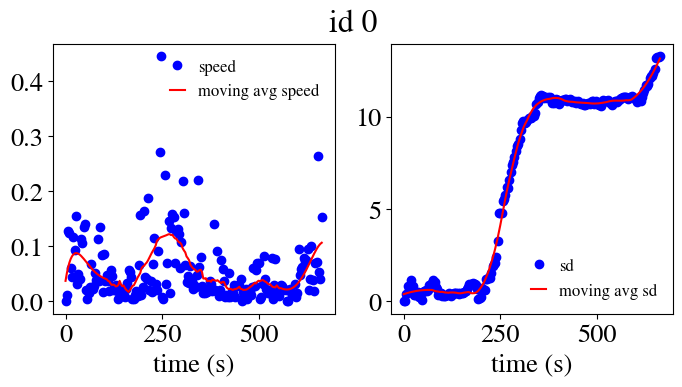

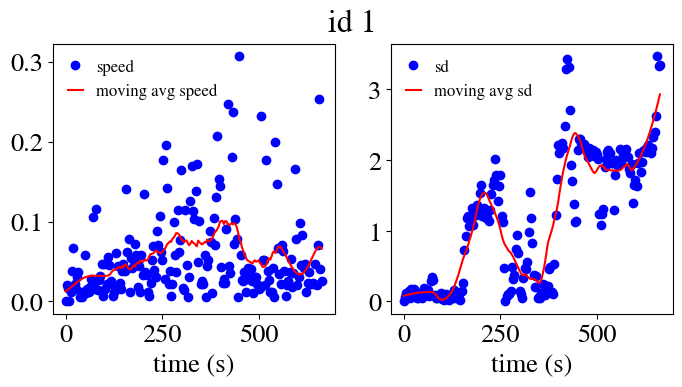

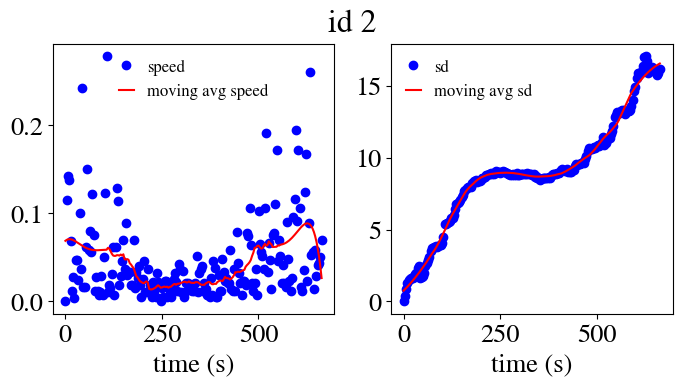

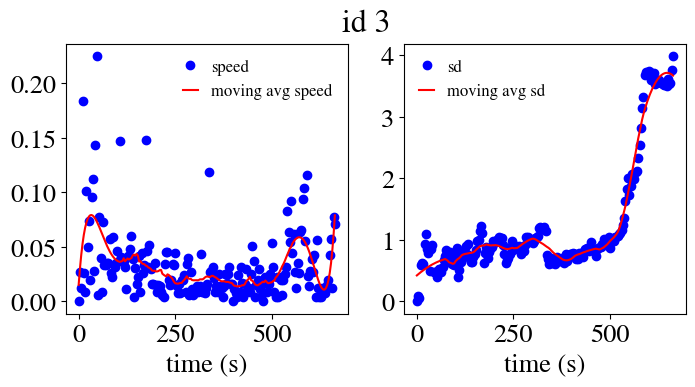

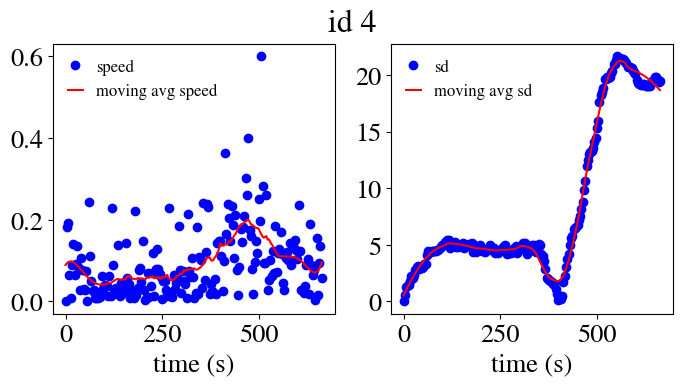

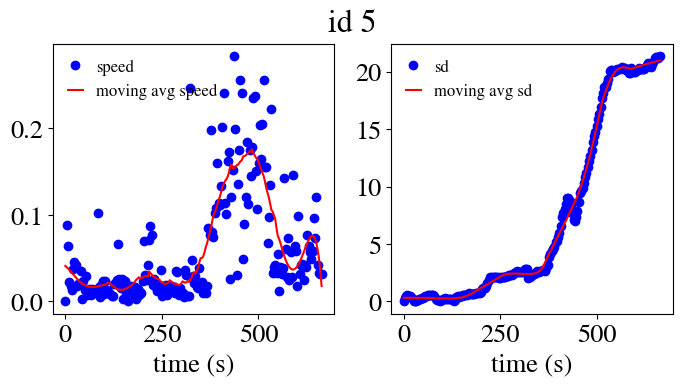

In [10]:
all_speeds_smooths = []
all_speeds = []
for id in computed_ids_isolated[:]:
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    sd = compute_sd(traj)
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values
    # sd = np.diff(x)**2 + np.diff(y)**2
    time = traj['t (sec)'].values
    speed = traj['speed'].values
    # sd_smooth = moving_average(sd,4)

    window_sd = 45
    order_sd = 2
    window_speed = 65
    order_speed = 5
    sd_smooth = savgol_filter(sd,window_sd,order_sd)

    speed_smooth = savgol_filter(speed,window_speed,order_speed) 
    plt.figure(figsize=(8,3.5))
    plt.suptitle(f'id {id}')
    plt.subplot(1,2,1)
    
    plt.plot(time,speed,'bo',label='speed')
    plt.plot(time,speed_smooth,lw=1.5,color='red',label='moving avg speed')
    plt.legend(fontsize=12,handlelength=0.9,frameon=False)
    # plt.figure(figsize=(4,4))
    # # plt.title(f'window = {window}',fontsize=14)
    plt.xlabel('time (s)')
    plt.subplot(1,2,2)
    plt.plot(time[:],sd,'bo',label='sd')
    plt.plot(time[:],sd_smooth,lw=1.5,color='red',label='moving avg sd')
    plt.legend(fontsize=12,handlelength=0.9,frameon=False)
    plt.xlabel('time (s)')
    plt.show()
    all_speeds_smooths += list(speed_smooth)
    all_speeds += list(speed)
    

    

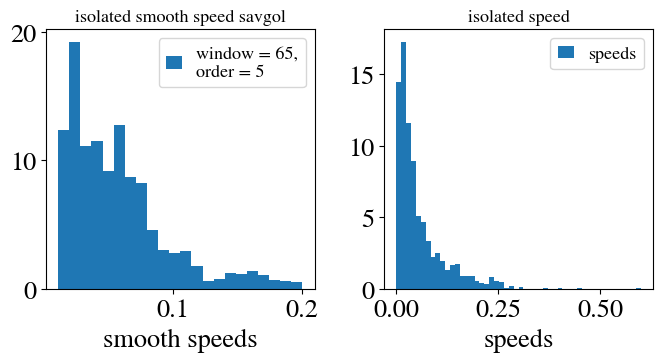

In [11]:
plt.figure(figsize=(7,4),layout='tight')
plt.subplot(1,2,1)

plt.hist(all_speeds_smooths,label=f'window = {window_speed},\norder = {order_speed}',bins='auto',density=True)
plt.xlabel('smooth speeds')
plt.title('isolated smooth speed savgol',fontsize=13)
plt.legend(fontsize=13,handlelength=0.9,frameon=True)
# plt.semilogy()
plt.subplot(1,2,2)

plt.hist(all_speeds,label='speeds',bins=50,density=True)
plt.xlabel('speeds')
plt.title('isolated speed',fontsize=13)
plt.legend(fontsize=13,handlelength=0.9,frameon=True)
# plt.semilogy()
plt.show()

In [50]:
from ruptures.base import BaseCost

class CostLinear(BaseCost):
    """Custom cost: piecewise linear fit (least squares error)."""

    model = "linear"
    min_size = 2  # Add this line!

    def fit(self, signal):
        self.signal = np.array(signal)
        return self

    def error(self, start, end):
        y = self.signal[start:end]
        x = np.arange(end - start)

        if len(y) < 2:  # prevent degenerate cases
            return 0

        # Fit a line: y = ax + b
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        y_fit = a * x + b
        error = np.sum((y - y_fit)**2)
        return error

    def cost(self, start, end):
        return self.error(start, end)

In [13]:
def slopes_compute(data, time, result, n, x, y):
    """
    Compute slopes of the squared displacement (SD) signal and displacements
    for each segment defined by change-point indices.

    Parameters
    ----------
    data :array
        1D array of the squared displacement (SD) values over time.
    time :array
        1D array of time values (e.g., frame indices).
    result: list of ints
        List of change-point indices from segmentation (typically from PELT),
        indicating the end of each segment.
    n : int
        Length of the data array.
    x: array
        1D array of x-positions over time (microns).
    y: array
        1D array of y-positions over time (microns).

    Returns
    -------
    slopes_list : array
        Array of shape (num_segments, 2), where each row contains the slope and intercept
        of the best linear fit to the SD signal within that segment.
    regions: attay
        Array of shape (num_segments, 2), where each row contains the [start, end]
        indices of the corresponding segment in time.
    disp_in_regions : array
        Array of net displacements (Euclidean distance) between start and end positions
        in each segment.
    """
    nbkp = len(result)  # Number of segments
    slopes_list = np.zeros((nbkp, 2))         # Store [slope, intercept] for each segment
    regions = np.zeros((nbkp, 2), dtype=int)  # Store [start, end] indices for each segment
    disp_in_regions = np.zeros(nbkp)          # Store displacement magnitude for each segment

    for i in range(nbkp):
        # Define start and end index of the current segment
        if i == 0:
            start = 0
        else:
            start = result[i - 1]

        # Handle end of trajectory
        if result[i] == n:
            end = n - 1
        else:
            end = result[i]

        # Compute displacement over the segment
        dx = x[end] - x[start]
        dy = y[end] - y[start]
        disp = np.sqrt(dx**2 + dy**2)
        disp_in_regions[i] = disp

        # Store the segment indices
        regions[i] = np.array([start, end])

        # Fit a line to the squared displacement data within this segment
        # [start+3:end-1] is used to avoid boundary artifacts
        params, _ = curve_fit(linear_fit, time[start + 3:end - 1], data[start + 3:end - 1])
        slopes_list[i] = np.array([params[0], params[1]])

    return slopes_list, regions, disp_in_regions

In [79]:
def find_plateaus_runs(traj, id, obs, smooth=False, piecewise_linear=False):
    """
    Detect plateau and run phases in bacterium traj using
    change-point detection on the squared displacement (SD) signal.

    Computes the squared displacement (SD) over time for a trajectory.
    Optionally it can me smoothed. Then we apply the PELT change-point detection algorithm to
    segment the signal into plateau/run-like regions. Returns the slopes and total displacements
    in each detected region.

    Parameters
    ----------
    traj : pandas.DataFrame
        A DataFrame containing at least the following columns:
        - 'Frame': time (or frame) indices,
        - 'x (micron)': x-position in microns,
        - 'y (micron)': y-position in microns.
    id : int or str
        trajectory id according to tracking
    obs : str
        Label or comment describing the observation, used in plot titles.
    smooth : bool, optional
        Whether to apply a Savitzky-Golay filter to smooth the squared displacement signal.
    piecewise_linear : bool, optional
        Whether to use a built-in piecewise linear cost model for segmentation.
        If False, a custom linear cost function is used instead.

    Returns
    -------
    slopes : array
        Array of linear slopes in each detected segment of the squared displacement signal.
    displacements : array
        Array of displacements corresponding to each segmented region.
    """
    # Extract basic trajectory data
    time = traj['Frame'].values
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values

    # Compute squared displacement (SD) signal (user-defined function)
    sd = compute_sd(traj)

    # Parameters for optional smoothing of SD signal
    window_sd = 33
    order_sd = 2
    if smooth:
        data = savgol_filter(sd, window_sd, order_sd)
    else:
        data = sd

    n = len(data)

    # Estimate noise level in SD signal by fitting a global linear trend to compute the penalty (perhaps this is not the best approach)
    coeffs = np.polyfit(np.arange(n), data, 1)
    resid = data - np.polyval(coeffs, np.arange(n))
    sigma2 = np.var(resid)
    pen = sigma2 * np.log(n)  # BIC-inspired penalty term

    # Change-point detection using PELT
    if piecewise_linear:
        alg = rpt.Pelt(model="l2", min_size=15, jump=1).fit(data)
    else:
        cost = CostLinear().fit(data)
        alg = rpt.Pelt(custom_cost=cost, min_size=12, jump=1).fit(data)

    # Predict change points (boundaries between plateau/run segments)
    result = alg.predict(pen=pen * 0.6)

    # Compute slopes and displacements for each detected region
    slopes_list, regions, disp_in_regions = slopes_compute(data, time, result, n, x, y)

    # Plot SD signal with detected segments and linear fits
    fig, ax = rpt.display(data, result, figsize=(4, 4), alpha=0.9)
    ax[0].set_xlabel('time (frames)')
    ax[0].set_ylabel('squared displacement')

    for i in range(len(result)):
        start, end = regions[i][0], regions[i][1]
        slope, b = slopes_list[i]
        half_x = (end + start) // 2

        segment_x = time[start:end]
        segment_y = linear_fit(segment_x, slope, b)

        ax[0].plot(segment_x, segment_y, alpha=0.8)
        #  label=fr'$\Delta r$ = {disp_in_regions[i]:.3f}' #disp label
        ax[0].annotate(f'{slope:.4f}', xy=(half_x - 1, data[half_x] + 0.1), fontsize=12)

    # ax[0].legend(fontsize=9, handlelength=0.8, frameon=False)
    ax[0].set_title(f'id {id}\n{obs}', fontsize=15)
    ax[0].set_xticks(result)
    ax[0].set_xticklabels(result, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Scatter plot: slope of SD vs total displacement in region
    # plt.figure(figsize=(4, 4))
    # plt.scatter(slopes_list[:, 0], disp_in_regions, s=20, color='red')
    # plt.xlabel('slope of squared displacement')
    # plt.ylabel('displacement in region')
    # plt.title(f'id {id}', fontsize=13)
    # plt.show()

    return slopes_list[:, 0], disp_in_regions

In [15]:
traj = dataframe_isolated[dataframe_isolated['Track ID']==5].sort_values('Frame')
traj['Obs']

Spot ID
4986    Collision between frames 117 and 160
4988    Collision between frames 117 and 160
4990    Collision between frames 117 and 160
4992    Collision between frames 117 and 160
4994    Collision between frames 117 and 160
                        ...                 
5586    Collision between frames 117 and 160
5594    Collision between frames 117 and 160
5596    Collision between frames 117 and 160
5600    Collision between frames 117 and 160
5602    Collision between frames 117 and 160
Name: Obs, Length: 200, dtype: object

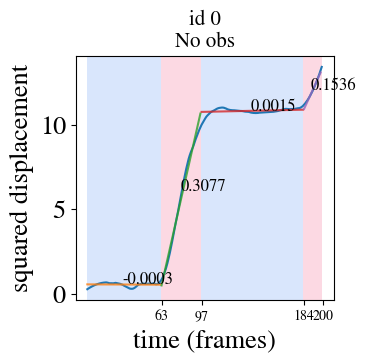

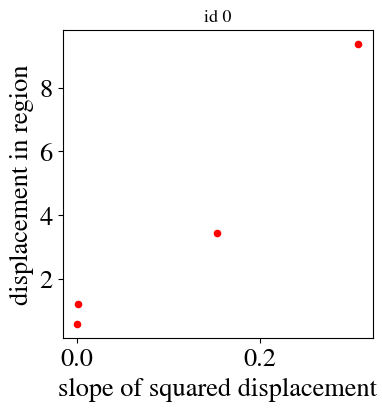

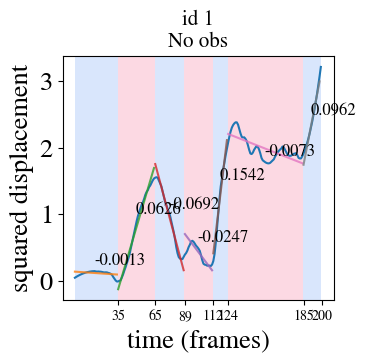

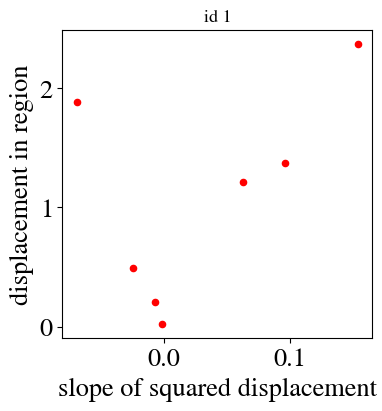

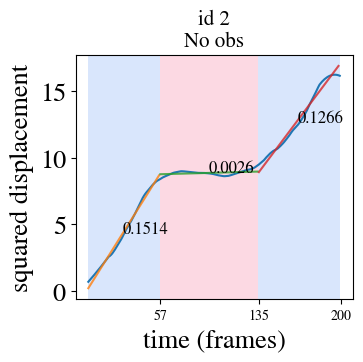

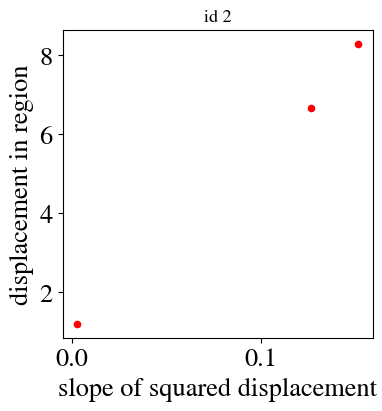

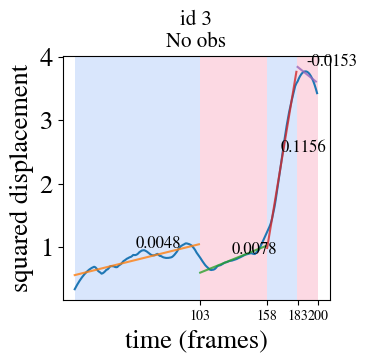

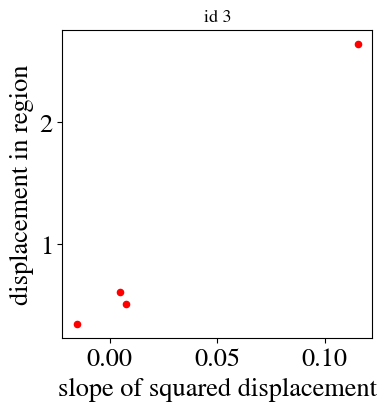

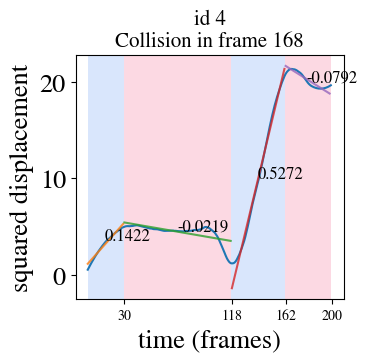

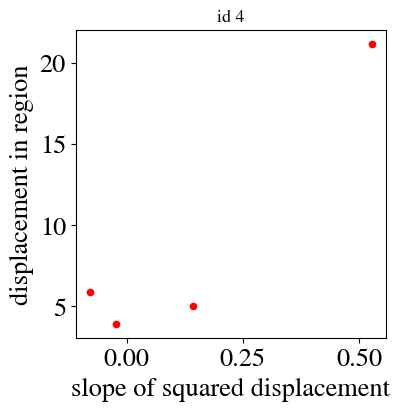

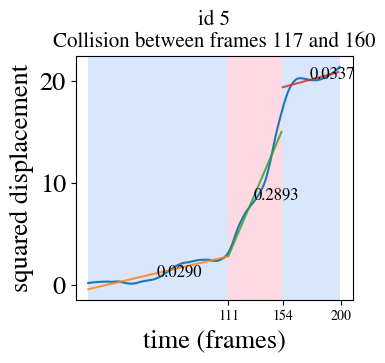

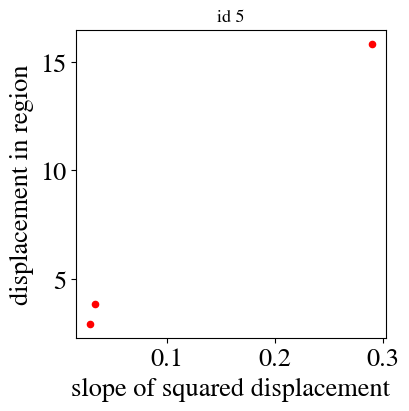

In [75]:
all_slopes_sd_isolated = []
all_disp_regions_isolated = []
for id in computed_ids_isolated:
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    obs = traj['Obs'].values[0]
    slopes_list,disp_in_regions=find_plateaus_runs(traj,id,obs,smooth=True,piecewise_linear=False)
    mask = slopes_list <= 1
    
    all_slopes_sd_isolated+=list(slopes_list[mask])
    all_disp_regions_isolated += list(disp_in_regions[mask])
    

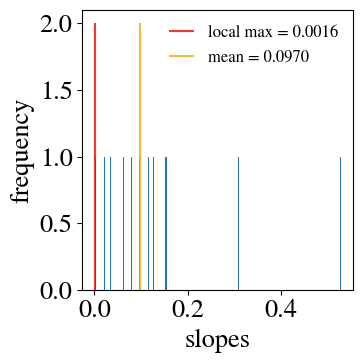

In [77]:
data = np.abs(all_slopes_sd_isolated) 
# data = data[data <= 0.2]
plt.figure(figsize=(4,4),layout='tight')
f = plt.hist(data,bins=600)
freq,bins = f[0],f[1]
bin_center = 0.5*(bins[1:] + bins[:-1])
max_prob = max(freq)
bin_max = bin_center[freq == max_prob][0]
plt.vlines(bin_max,0,max(freq),lw = 1.5,color='red',alpha = 0.8,label = f'local max = {bin_max:.4f}')
plt.vlines(np.mean(data),0,max(freq),lw = 1.5,color='orange',alpha = 0.8,label = f'mean = {np.mean(data):.4f}')
plt.xlabel('slopes')
plt.ylabel('frequency')
plt.legend(fontsize=12,handlelength=1.5,frameon=False)
# plt.xlim(0,0.1)
# plt.semilogx()
plt.show()

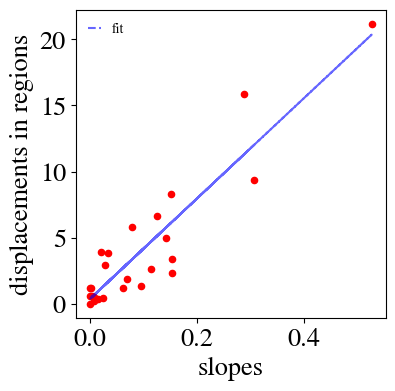

f(x) = ax + b
a = 37.896, b = 0.364


In [78]:
plt.figure(figsize=(4,4))
mask = data <= 50
x = data[mask]
y = np.array(all_disp_regions_isolated)[mask]
pcov,perr = curve_fit(linear_fit,x,y)
plt.scatter(x,y,s=20,color='red')
plt.plot(x,linear_fit(x,*pcov),label='fit',color='blue',lw=1.5, ls='--',alpha=0.6)
# label = f'y = ax + b\na = {pcov[0]:.3f}, b = {pcov[1]:.3f}'
plt.xlabel('slopes')
plt.ylabel('displacements in regions')
plt.legend(fontsize=10,handlelength=0.9,frameon=False)
# plt.loglog()
plt.show()
print(f'f(x) = ax + b\na = {pcov[0]:.3f}, b = {pcov[1]:.3f}')

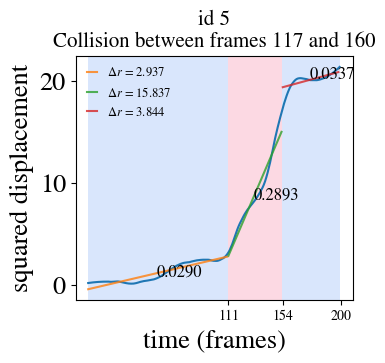

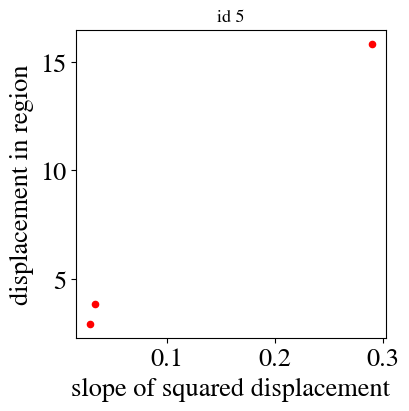

In [63]:
id = 5
traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')


slopes_list,disp_in_regions=find_plateaus_runs(traj,id,obs,smooth=True,piecewise_linear=False)


In [64]:
x = traj['x (micron)'].values
y = traj['y (micron)'].values
# speed = traj['speed'].values
time = traj['Frame'].values
sd = compute_sd(traj)
window_sd = 33
order_sd = 2
sd_smooth = savgol_filter(sd,window_sd,order_sd)
n = len(sd)

# Estimate noise by fitting one global line:
coeffs = np.polyfit(np.arange(n), sd_smooth, 1)
resid = sd_smooth - np.polyval(coeffs, np.arange(n))
sigma2 = np.var(resid)
pen = sigma2 * np.log(n)  # BIC-inspired penalty term
cost = CostLinear().fit(sd_smooth)
# alg = rpt.Pelt(custom_cost=cost, min_size=12, jump=1).fit(sd_smooth)
alg = rpt.Pelt(model="l2", min_size=12, jump=1).fit(sd_smooth)
result= alg.predict(pen=pen*0.6)
nbkp = len(result)

In [65]:
slopes_list = np.zeros((nbkp,2))
regions = np.zeros((nbkp,2),dtype=int)
disp_in_regions = np.zeros(nbkp)
for i in range(len(result)):
    
    if i == 0:
        start = 0
        # end = result[i+1]
    else:
        
        start = result[i-1]
    if result[i] == n:
        end = n-1
    else:
        end = result[i]
    print(f'region [{start},{end}]')
    dx = x[end] - x[start]
    dy = y[end] - y[start]
    disp = np.sqrt(dx**2 + dy**2)
    disp_in_regions[i] = disp
    
    
    regions[i] =np.array([start,end])
    params, _ = curve_fit(linear_fit, time[start + 3:end - 1], sd_smooth[start + 3:end - 1])
    slope = params[0]
    slopes_list[i] = np.array([params[0], params[1]])
    # slope = (sd[end]-sd[start])/(time[end]-time[start])
    print(f'slope = {slope:.4f}\ndisp = {disp:.4f}\n--------------------------\n')
    # slopes_list.append([params[0],params[1]])

    slopes_list[i] = np.array([params[0],params[1]])

region [0,65]
slope = 0.0105
disp = 1.5832
--------------------------

region [65,116]
slope = 0.0256
disp = 2.9854
--------------------------

region [116,132]
slope = 0.2022
disp = 4.3126
--------------------------

region [132,145]
slope = 0.3236
disp = 5.5580
--------------------------

region [145,157]
slope = 0.4796
disp = 6.6575
--------------------------

region [157,199]
slope = 0.0247
disp = 2.8044
--------------------------



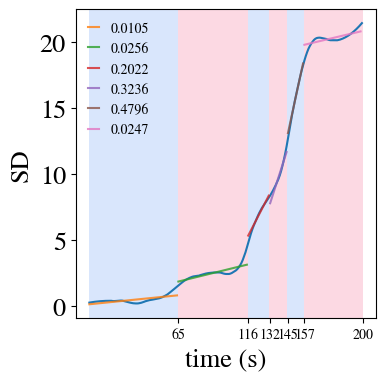

In [66]:
fig,ax = rpt.display(sd_smooth, result,figsize=(4,4))
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('SD')
for i in range(len(result)):
    start,end = regions[i][0],regions[i][1]
    slope,b = slopes_list[i][0],slopes_list[i][1]
    x = time[start:end]
    y = linear_fit(x,slope,b)
    
    # print(x)
    

    ax[0].plot(x,y,label=f'{slope:.4f}',alpha=0.8)
ax[0].legend(fontsize=10,handlelength=0.8,frameon=False)

ax[0].set_xticks(result)
ax[0].set_xticklabels(result,fontsize=10)

plt.show()

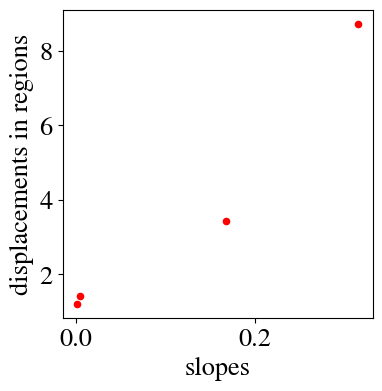

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(slopes_list[:,0],disp_in_regions,s=20,color='red')
plt.xlabel('slopes')
plt.ylabel('displacements in regions')
plt.show()

Trying change-point identification with speed

pen = 0.1


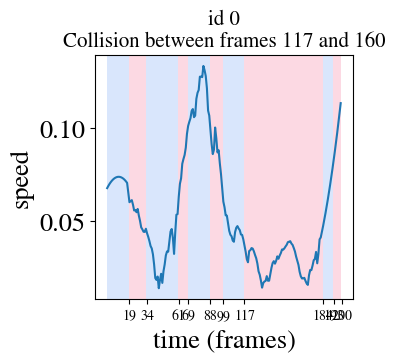

pen = 0.2


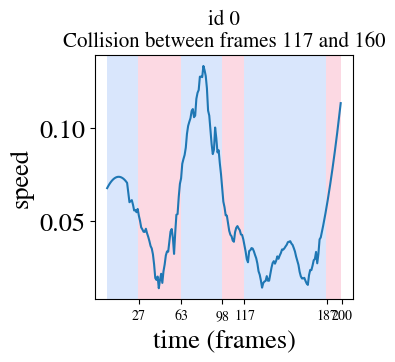

pen = 0.3


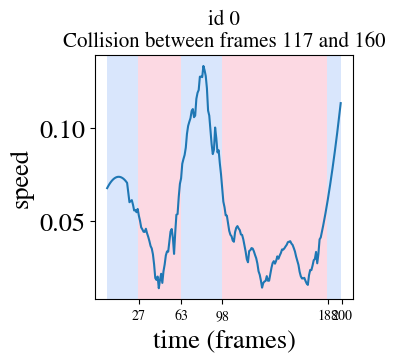

pen = 0.4


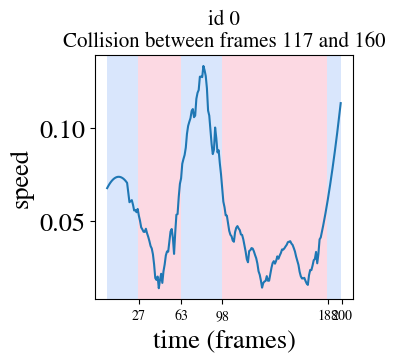

pen = 0.5


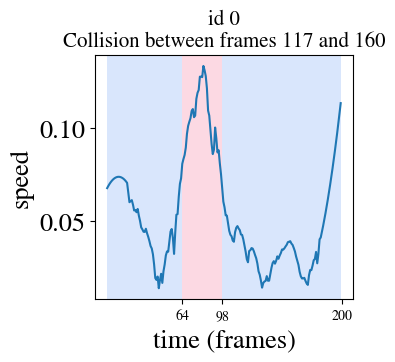

In [23]:
# speed_smooth = speed
window_sd = 35
order_sd = 2
speed_smooth =savgol_filter(speed,window_sd,order_sd)
n = len(speed_smooth)

# Estimate noise by fitting one global line:
# coeffs = np.polyfit(np.arange(n), speed_smooth, 1)
# resid  = sd - np.polyval(coeffs, np.arange(n))
# sigma2 = np.var(resid)
for pen in [0.1,0.2,0.3,0.4,0.5]:
    print(f'pen = {pen}')
    alg = rpt.Pelt(model="l1",min_size=1,jump=1).fit(speed_smooth)
    result= alg.predict(pen=pen)
    fig,ax = rpt.display(speed_smooth, result,figsize=(4,4))
    ax[0].set_xlabel('time (frames)')
    ax[0].set_ylabel('speed')

    ax[0].set_title(f'id {id}\n{obs}',fontsize=15)
    ax[0].set_xticks(result)
    ax[0].set_xticklabels(result,fontsize=10)
    plt.tight_layout()
    plt.show()
